In [1]:
import pickle
import os
import sys
import json
from tqdm import tqdm
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import rdkit.Chem as Chem
from fragmentation_py import FragmentEngine
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import visualizer as visualizer
import numpy as np

generate first molecule

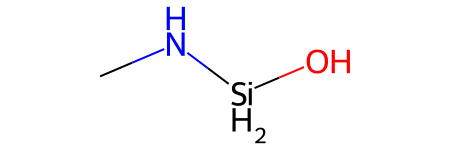

In [2]:
# empty editable molecule
initialMol = Chem.RWMol()

# add atoms
initialMol.AddAtom(Chem.Atom(6))
initialMol.AddAtom(Chem.Atom(7))
initialMol.AddAtom(Chem.Atom(14))
initialMol.AddAtom(Chem.Atom(8))

# add bonds
initialMol.AddBond(0, 1, Chem.BondType.SINGLE)
initialMol.AddBond(1, 2, Chem.BondType.SINGLE)
initialMol.AddBond(2, 3, Chem.BondType.SINGLE)


# check if mol is good:
try:
    mol = initialMol.GetMol()
    s = Chem.MolToSmiles(mol)
    mol = Chem.MolFromSmiles(s, sanitize=True)
except:
    print("mol is bad")
mol

genarate peaks:

In [46]:
def generate_peaks(mol, fragments = None):
    if fragments is None:
        fragments = FragmentEngine(Chem.MolToMolBlock(mol), 1, 1, 1, 0, 0)
        fragments.generate_fragments()
    w = fragments.fragment_masses_np[:, 1]
    w_sorted_index = np.argsort(w)
    w_sorted_index = w_sorted_index[w[w_sorted_index] > 0]
    
    peaks = []
    indices = []
    for i in w_sorted_index:
        fragment = fragments.fragment_info[i]
        indice = fragments.get_fragment_info(fragment[0], 0)[1]
        weight = round(fragments.fragment_masses_np[i][1], 2)
        peaks.append((weight, 1))
        indices.append(indice)
    
    peaks_weight = [peak[0] for peak in peaks]
    peaks_weight_unique = list(set(peaks_weight))
    peaks_weight_unique.sort()
    peaks = []
    new_indices = []
    for weight in peaks_weight_unique:
        peaks.append((weight, 1))
        new_indices.append(indices[peaks_weight.index(weight)])
    return peaks, new_indices

visualize peaks:

[(15.02, 1), (17.0, 1), (29.99, 1), (30.03, 1), (45.0, 1), (47.0, 1), (60.03, 1), (62.01, 1), (77.03, 1)]


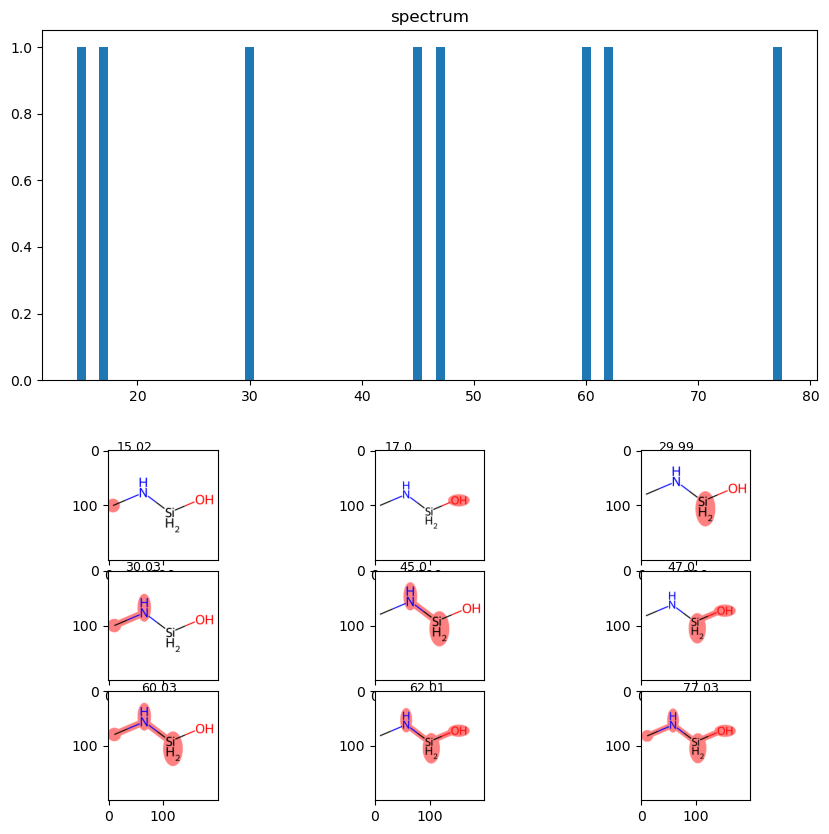

In [47]:
fragments = FragmentEngine(Chem.MolToMolBlock(mol), 1, 1, 1, 0, 0)
fragments.generate_fragments()
peaks, indices = generate_peaks(mol, fragments)

labels = [peak[0] for peak in peaks]
values = [peak[1] for peak in peaks]

print(peaks)

fig = plt.figure(figsize=(10, 10))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.2)
ax = plt.Subplot(fig, outer[0])
ax.set_title("spectrum")
ax.bar(labels, values)
fig.add_subplot(ax)

rows = math.ceil(math.sqrt(len(labels)))
cols = math.floor(len(labels)/rows)

inner = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=outer[1], wspace=0.1, hspace=0.1)

for i, (label, value) in enumerate(zip(labels, values)):
    ax = plt.Subplot(fig, inner[i])
    highlight = indices[i]
    highlilghtBonds = []
    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() in highlight and bond.GetEndAtomIdx() in highlight:
            highlilghtBonds.append(bond.GetIdx())
    img = Chem.Draw.MolToImage(mol, size=(200, 200), highlightAtoms=highlight, highlightBonds=highlilghtBonds)
    ax.text(label, value+0.05, str(label), fontsize=9)
    ax.imshow(img)
    fig.add_subplot(ax)
plt.show()

generate modified versions

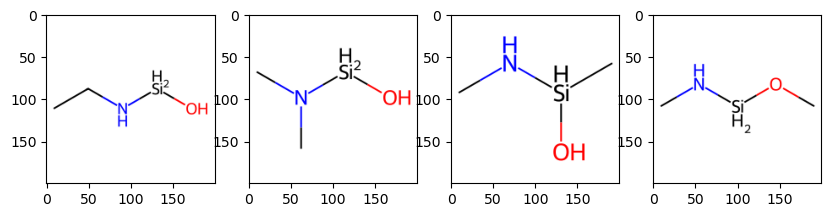

In [48]:
modifiedVersions = []
for i in range(initialMol.GetNumAtoms()):
    modifiedInitialMol = Chem.RWMol(initialMol)
    modifiedInitialMol.AddAtom(Chem.Atom(6))
    modifiedInitialMol.AddBond(i, modifiedInitialMol.GetNumAtoms()-1, Chem.BondType.SINGLE)
    modifiedMol = modifiedInitialMol.GetMol()
    s = Chem.MolToSmiles(modifiedMol)
    modifiedMol = Chem.MolFromSmiles(s, sanitize=True)
    modifiedVersions.append(modifiedMol)

fig, ax = plt.subplots(1, len(modifiedVersions), figsize=(10, 10))
for i, modifiedVersion in enumerate(modifiedVersions):
    img = Chem.Draw.MolToImage(modifiedVersion, size=(200, 200))
    ax[i].imshow(img)

In [49]:
import Compound_n as Compound
def generate_compound(mol, peaks):
    # unique peaks based on weight
    peaks_weight = [peak[0] for peak in peaks]
    peaks_weight_unique = list(set(peaks_weight))
    peaks_weight_unique.sort()
    peaks = []
    for weight in peaks_weight_unique:
        peaks.append((weight, peaks_weight.count(weight)))
    data = {}
    data["Smiles"] = Chem.MolToSmiles(mol)
    data["peaks"] = peaks
    data["Adduct"] = "M+H"
    data["Precursor_MZ"] = Chem.rdMolDescriptors.CalcExactMolWt(mol)
    data["Charge"] = 1
    return Compound.Compound(data)

[-0.8, -0.6, -0.4, -0.2, 0.0, 0.1, 0.30000000000000004, 0.5, 0.7, 0.9]
[0.8, 0.6, 0.4, 0.2, 0.0, 0.0, 0.2, 0.4, 0.6, 0.8]


<AxesSubplot: >

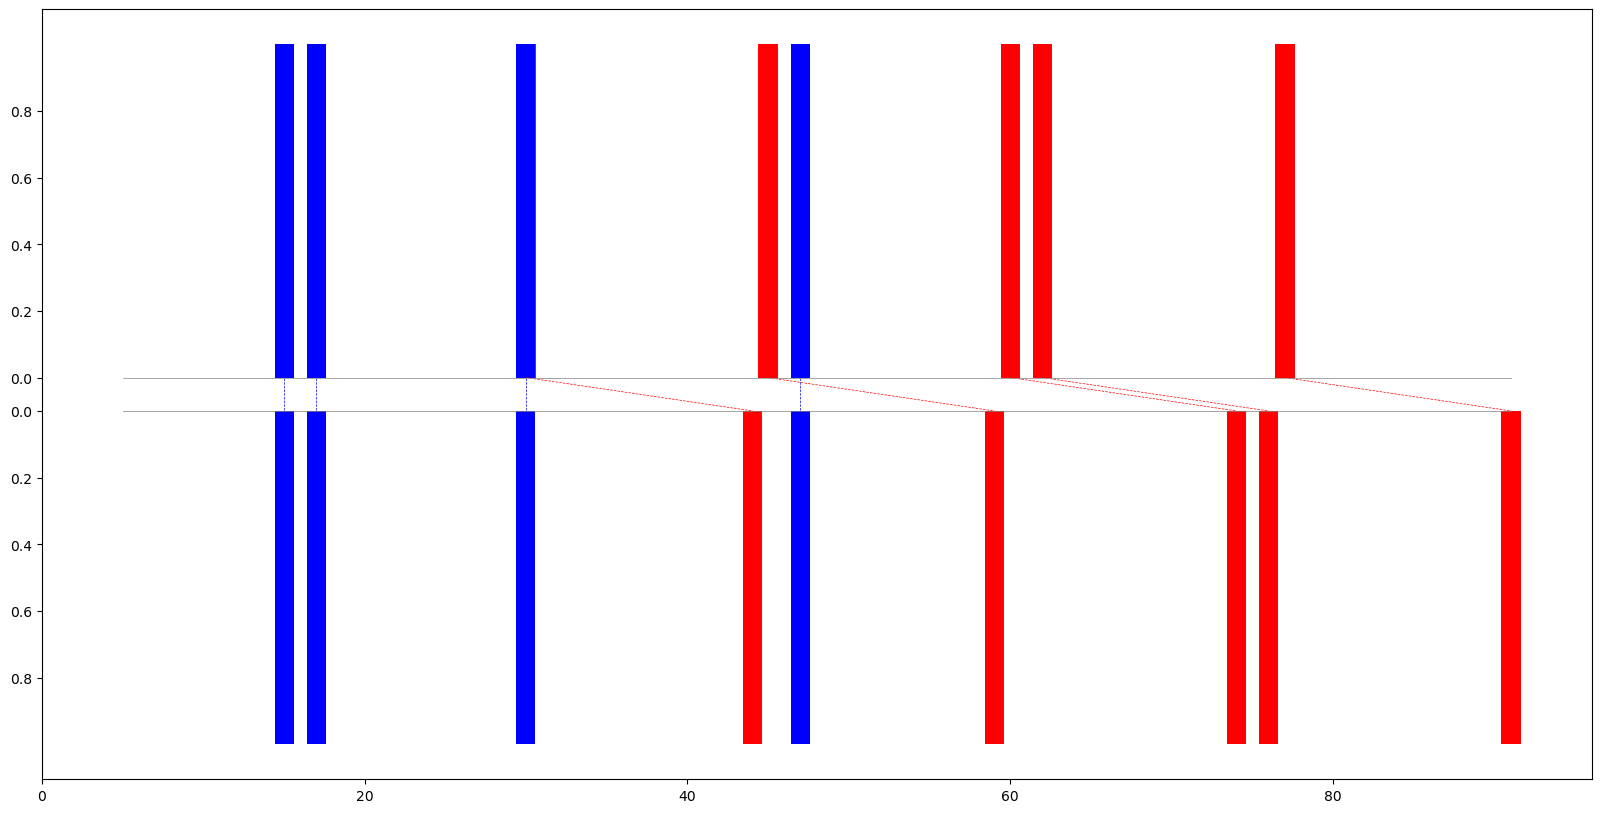

In [50]:
from alignment_n import align

i = 1
modifiedVersion = modifiedVersions[i]

modified_peaks, modified_indices = generate_peaks(modifiedVersion)
main_compound = generate_compound(mol, peaks)
modified_compound = generate_compound(modifiedVersion, modified_peaks)
cosign, matched_peaks = align(main_compound, modified_compound)
visualizer.draw_alignment(peaks1=peaks, peaks2=modified_peaks, matched_peaks=matched_peaks)

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 5), (5, 4), (6, 6), (7, 7), (8, 8)]
[(15.02, 1), (17.0, 1), (29.99, 1), (30.03, 1), (45.0, 1), (47.0, 1), (60.03, 1), (62.01, 1), (77.03, 1)]
[(15.02, 1), (17.0, 1), (29.99, 1), (44.05, 1), (47.0, 1), (59.02, 1), (74.04, 1), (76.02, 1), (91.05, 1)]


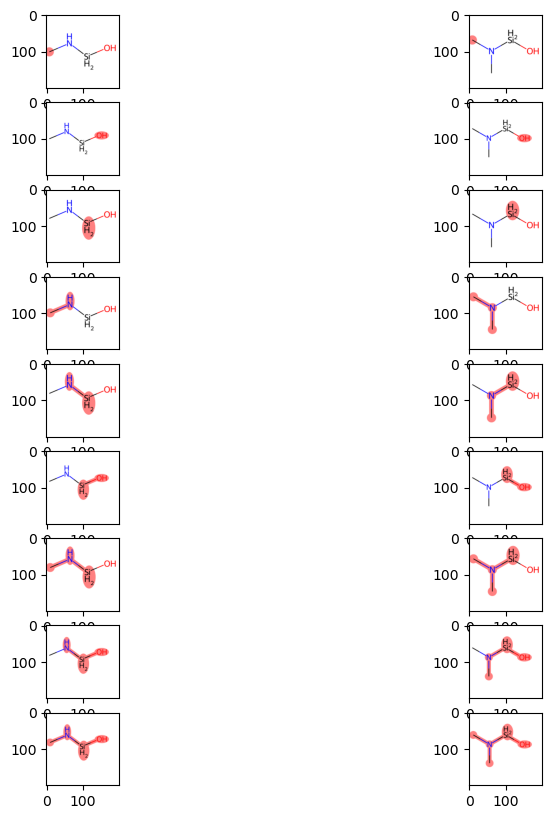

In [53]:
fig, ax = plt.subplots(len(matched_peaks), 2, figsize=(10, 10))
matched_peaks = sorted(matched_peaks, key=lambda x: x[0])
print(matched_peaks)
print(peaks)
print(modified_peaks)
for i, (peak1, peak2) in enumerate(matched_peaks):
    highlight = indices[peak1]
    highlilghtBonds = []
    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() in highlight and bond.GetEndAtomIdx() in highlight:
            highlilghtBonds.append(bond.GetIdx())
    img1 = Chem.Draw.MolToImage(mol, size=(200, 200), highlightAtoms=highlight, highlightBonds=highlilghtBonds)
    
    highlight = modified_indices[peak2]
    highlilghtBonds = []
    for bond in modifiedVersion.GetBonds():
        if bond.GetBeginAtomIdx() in highlight and bond.GetEndAtomIdx() in highlight:
            highlilghtBonds.append(bond.GetIdx())
    
    img2 = Chem.Draw.MolToImage(modifiedVersion, size=(200, 200), highlightAtoms=highlight, highlightBonds=highlilghtBonds)
    ax[i, 0].imshow(img1)
    ax[i, 1].imshow(img2)

In [58]:
pair = []
for modifiedVersion in modifiedVersions:

    peaks, indices = generate_peaks(mol)
    mol_data = {}
    mol_data["Smiles"] = Chem.MolToSmiles(mol)
    mol_data["peaks_json"] = json.dumps(peaks)
    mol_data["Adduct"] = "M+H"
    mol_data["Precursor_MZ"] = Chem.rdMolDescriptors.CalcExactMolWt(mol)
    mol_data["Charge"] = 1

    modified_peaks, modified_indices = generate_peaks(modifiedVersion)
    modified_data = {}
    modified_data["Smiles"] = Chem.MolToSmiles(modifiedVersion)
    modified_data["peaks_json"] = json.dumps(modified_peaks)
    modified_data["Adduct"] = "M+H"
    modified_data["Precursor_MZ"] = Chem.rdMolDescriptors.CalcExactMolWt(modifiedVersion)
    modified_data["Charge"] = 1

    pair.append((mol_data, modified_data))

with open("synthetic1.json", "w") as f:
    json.dump(pair, f)
